# Creating Learning Model for Rust Detection on any Steels

# 1. Preparation

In [ ]:
pip install pillow

Importing all necessary library

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pydot
import matplotlib.pyplot as plt
from keras.applications import Xception
from keras import Model
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import random
import shutil
from shutil import copyfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining paths

In [ ]:
source_dir = "/content/drive/MyDrive/Machine Learning"
norust = "/content/drive/MyDrive/Machine Learning/norust"
rust = "/content/drive/MyDrive/Machine Learning/rusts"

Renaming datasets / files

In [ ]:
# Rename file
norust_chdir = os.chdir(norust)
len(os.listdir(norust_chdir))

i = 0
for file in os.listdir(norust_chdir):
  new_file_name = "norust{}.jpg".format(i)
  os.rename(file, new_file_name)
  i = i + 1

In [ ]:
rust_chdir = os.chdir(rust)
len(os.listdir(rust_chdir))

n = 0
for file in os.listdir(rust_chdir):
  new_file_name = "rusty{}.jpg".format(n)
  os.rename(file, new_file_name)
  n = n + 1

In [ ]:
!pwd

/content/drive/MyDrive/Machine Learning/rusts


In [ ]:
print(len(os.listdir(norust)))
print(len(os.listdir(rust)))

163
163


In [ ]:
# Re-check order
for files in os.listdir(norust_chdir):
    print(files)

for file in os.listdir(rust_chdir):
    print(file)

rusty0.png
rusty1.png
rusty2.png
rusty3.png
rusty4.png
rusty5.png
rusty6.png
rusty7.png
rusty8.png
rusty9.png
rusty10.png
rusty11.png
rusty12.png
rusty13.png
rusty14.png
rusty15.png
rusty16.png
rusty17.png
rusty18.png
rusty19.png
rusty20.png
rusty21.png
rusty22.png
rusty23.png
rusty24.png
rusty25.png
rusty26.png
rusty27.png
rusty28.png
rusty29.png
rusty30.png
rusty31.png
rusty32.png
rusty33.png
rusty34.png
rusty35.png
rusty36.png
rusty37.png
rusty38.png
rusty39.png
rusty40.png
rusty41.png
rusty42.png
rusty43.png
rusty44.png
rusty45.png
rusty46.png
rusty47.png
rusty48.png
rusty49.png
rusty50.png
rusty51.png
rusty52.png
rusty53.png
rusty54.png
rusty55.png
rusty56.png
rusty57.png
rusty58.png
rusty59.png
rusty60.png
rusty61.png
rusty62.png
rusty63.png
rusty64.png
rusty65.png
rusty66.png
rusty67.png
rusty68.png
rusty69.png
rusty70.png
rusty71.png
rusty72.png
rusty73.png
rusty74.png
rusty75.png
rusty76.png
rusty77.png
rusty78.png
rusty79.png
rusty80.png
rusty81.png
rusty82.png
rusty83.png
ru

Creating directory for training set and testing set

In [ ]:
# Create Directory
os.makedirs(os.path.join(source_dir, 'training'))
os.makedirs(os.path.join(f'{source_dir}/training', 'rust'))
os.makedirs(os.path.join(f'{source_dir}/training', 'norust'))
os.makedirs(os.path.join(source_dir, 'testing'))
os.makedirs(os.path.join(f'{source_dir}/testing', 'rust'))
os.makedirs(os.path.join(f'{source_dir}/testing', 'norust'))

Defining training and testing directory path

In [ ]:
TRAINING_DIR = "/content/drive/MyDrive/Machine Learning/training"
VALIDATION_DIR = "/content/drive/MyDrive/Machine Learning/testing"

TRAINING_N_DIR = "/content/drive/MyDrive/Machine Learning/training/norust/"
TRAINING_R_DIR = "/content/drive/MyDrive/Machine Learning/training/rust/"
TESTING_N_DIR = "/content/drive/MyDrive/Machine Learning/testing/norust/"
TESTING_R_DIR = "/content/drive/MyDrive/Machine Learning/testing/rust/"

# 2. Splitting datasets into Training and Validation

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    files = os.listdir(SOURCE_DIR)
    random.shuffle(files)

    split = int(len(files) * SPLIT_SIZE)

    for i, filename in enumerate(files):
        if os.path.getsize(os.path.join(SOURCE_DIR, filename)) == 0:
            print(f'{filename} is zero length, so ignoring.')
            continue

        if i < split:
            destination = os.path.join(TRAINING_DIR, filename)
        else:
            destination = os.path.join(VALIDATION_DIR, filename)

        source = os.path.join(SOURCE_DIR, filename)
        copyfile(source, destination)

In [ ]:
split_size= 0.8
split_data(norust, TRAINING_N_DIR, TESTING_N_DIR, split_size)
split_data(rust, TRAINING_R_DIR, TESTING_R_DIR, split_size)

print(f"\n\nOriginal norust's directory has {len(os.listdir(norust))} images")
print(f"Original rust's directory has {len(os.listdir(rust))} images\n")
print(f"There are {len(os.listdir(TRAINING_N_DIR))} images of no-rust for training")
print(f"There are {len(os.listdir(TRAINING_R_DIR))} images of rust for training")
print(f"There are {len(os.listdir(TESTING_N_DIR))} images of no-rust for validation")
print(f"There are {len(os.listdir(TESTING_R_DIR))} images of rust for validation")



Original norust's directory has 163 images
Original rust's directory has 163 images

There are 130 images of no-rust for training
There are 130 images of rust for training
There are 33 images of no-rust for validation
There are 33 images of rust for validation


In [ ]:
len(os.listdir(TRAINING_DIR))
len(os.listdir(VALIDATION_DIR))

2

this code is for deleting datasets that has been distributed into training and testing folder

In [ ]:
# USE THIS CODE ONLY FOR CLEAN UP
if len(os.listdir(TRAINING_N_DIR)) > 0:
  for file in os.scandir(TRAINING_N_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_R_DIR)) > 0:
  for file in os.scandir(TRAINING_R_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_N_DIR)) > 0:
  for file in os.scandir(TESTING_N_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_R_DIR)) > 0:
  for file in os.scandir(TESTING_R_DIR):
    os.remove(file.path)

print(f"There are {len(os.listdir(TRAINING_N_DIR))} images of no-rust for training")
print(f"There are {len(os.listdir(TRAINING_R_DIR))} images of rust for training")
print(f"There are {len(os.listdir(TESTING_N_DIR))} images of no-rust for validation")
print(f"There are {len(os.listdir(TESTING_R_DIR))} images of rust for validation")

There are 0 images of no-rust for training
There are 0 images of rust for training
There are 0 images of no-rust for validation
There are 0 images of rust for validation


Make Labels

In [ ]:
class_labels = ['No-Rust', 'Rusty']
os.chdir("/content/drive/MyDrive/Machine Learning/model")
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_labels))

# 3. Augmenting Datasets

In [ ]:
def train_val_gen(TRAINING_DIR,VALIDATION_DIR):
  train_datagen = ImageDataGenerator(
      rescale= 1.0/255.0,
      rotation_range = 40,
      zoom_range=0.25,
      shear_range=0.25,
      width_shift_range=0.4,
      height_shift_range=0.4,
      fill_mode="nearest",
      horizontal_flip=True,
      vertical_flip=True
  )
  validation_datagen = ImageDataGenerator(
      rescale=1.0/255.0
  )

  train_gen = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=32,
      class_mode='categorical',
      target_size=(224,224)
  )
  validation_gen = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=32,
      class_mode='categorical',
      target_size=(224,224)
  )

  return train_gen,validation_gen

In [ ]:
train_gen, validation_gen = train_val_gen(TRAINING_DIR,VALIDATION_DIR)

val_labels = validation_gen.class_indices
print(val_labels)

Found 260 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
{'norust': 0, 'rust': 1}


# 4. Creating Model Architecture

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
   base_model,
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dense(256, activation='relu'),
   tf.keras.layers.Dropout(0.3),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 9 (GlobalAveragePooling2D)                                      
                                                                 
 dense_56 (Dense)            (None, 256)               524544    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_31 (Ba  (None, 128)               512       
 tchNormalization)                                   

In [ ]:
class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.88 and logs.get('val_accuracy') > 0.88:
      self.model.stop_training = True

In [ ]:
# Compile Model
callback = modelCallback()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(train_gen, epochs=15, validation_data=validation_gen, callbacks=callback)

Epoch 1/15
8/9 [=========================>....] - ETA: 0s - loss: 0.7613 - accuracy: 0.5789

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 [==============================] - 18s 1s/step - loss: 0.7523 - accuracy: 0.5846 - val_loss: 0.6766 - val_accuracy: 0.5909
Epoch 2/15
9/9 [==============================] - 7s 799ms/step - loss: 0.6221 - accuracy: 0.6769 - val_loss: 0.6595 - val_accuracy: 0.6212
Epoch 3/15
9/9 [==============================] - 9s 946ms/step - loss: 0.5567 - accuracy: 0.7038 - val_loss: 0.6368 - val_accuracy: 0.6818
Epoch 4/15
9/9 [==============================] - 15s 2s/step - loss: 0.5539 - accuracy: 0.7077 - val_loss: 0.6084 - val_accuracy: 0.7727
Epoch 5/15
9/9 [==============================] - 7s 790ms/step - loss: 0.4896 - accuracy: 0.7577 - val_loss: 0.5807 - val_accuracy: 0.8788
Epoch 6/15
9/9 [==============================] - 9s 1s/step - loss: 0.4732 - accuracy: 0.7731 - val_loss: 0.5520 - val_accuracy: 0.9091
Epoch 7/15
9/9 [==============================] - 8s 930ms/step - loss: 0.4085 - accuracy: 0.8308 - val_loss: 0.5320 - val_accuracy: 0.9394
Epoch 8/15
9/9 [======================

Post-Training Validation

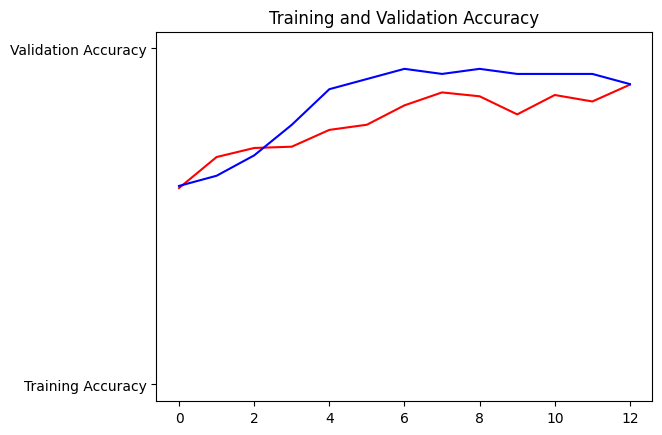

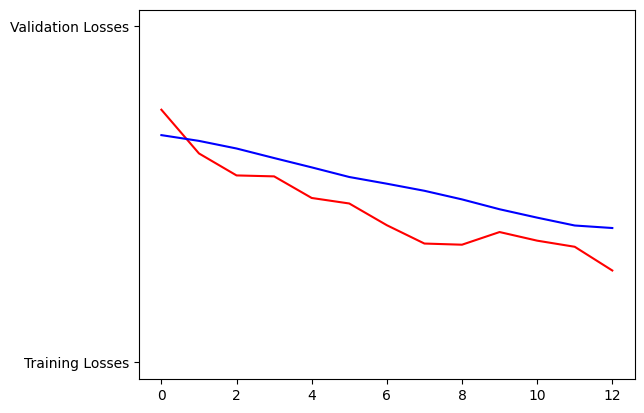

In [ ]:
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epoch=range(len(acc))

plt.plot(epoch, acc, 'r', "Training Accuracy")
plt.plot(epoch, val_acc, 'b', "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.show()
print("")

plt.plot(epoch, loss, 'r', "Training Losses")
plt.plot(epoch, val_loss, 'b', "Validation Losses")
plt.show()

Fine-Tuning

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_8[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [ ]:
print('Number of layers in the Xception Model : ', len(base_model.layers))

pick_layer = base_model.get_layer("add_42")
pick_layer_index = base_model.layers.index(pick_layer)
# Here I am training the layers from add_42 layer onwards.
for layer in base_model.layers[pick_layer_index:]:
    layer.trainable=True

Number of layers in the Xception Model :  132


In [ ]:
model_tuned = tf.keras.Sequential([
   base_model,
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dense(2, activation='softmax')
])

model_tuned.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss = loss,
    metrics=['accuracy']
)

In [ ]:
history_tuned = model.fit(train_gen, epochs=10, validation_data=validation_gen)

Epoch 1/10
2/9 [=====>........................] - ETA: 5s - loss: 0.2849 - accuracy: 0.8594

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 [==============================] - 10s 1s/step - loss: 0.3131 - accuracy: 0.8577 - val_loss: 0.3916 - val_accuracy: 0.9091
Epoch 2/10
9/9 [==============================] - 8s 843ms/step - loss: 0.3468 - accuracy: 0.8692 - val_loss: 0.3896 - val_accuracy: 0.8939
Epoch 3/10
9/9 [==============================] - 8s 902ms/step - loss: 0.2866 - accuracy: 0.9000 - val_loss: 0.3805 - val_accuracy: 0.9242
Epoch 4/10
9/9 [==============================] - 10s 1s/step - loss: 0.2658 - accuracy: 0.9115 - val_loss: 0.3658 - val_accuracy: 0.9091
Epoch 5/10
9/9 [==============================] - 7s 813ms/step - loss: 0.2803 - accuracy: 0.9038 - val_loss: 0.3514 - val_accuracy: 0.9091
Epoch 6/10
9/9 [==============================] - 9s 980ms/step - loss: 0.2420 - accuracy: 0.9269 - val_loss: 0.3334 - val_accuracy: 0.9242
Epoch 7/10
9/9 [==============================] - 8s 837ms/step - loss: 0.2489 - accuracy: 0.9038 - val_loss: 0.3212 - val_accuracy: 0.9242
Epoch 8/10
9/9 [===================

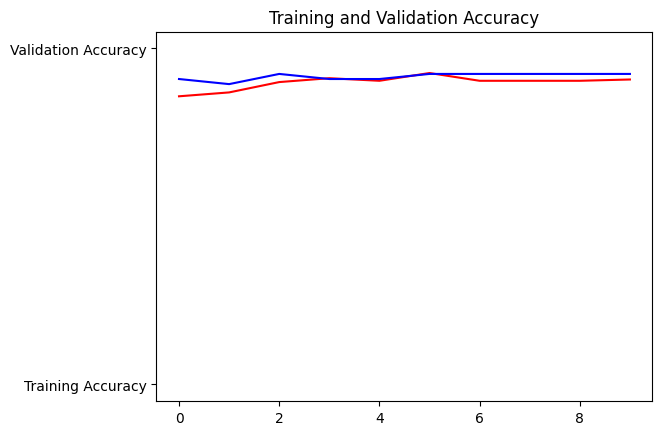

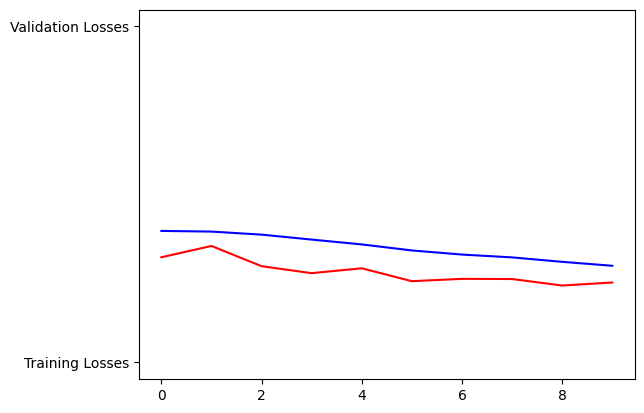

In [ ]:
acc = history_tuned.history['accuracy']
val_acc=history_tuned.history['val_accuracy']
loss=history_tuned.history['loss']
val_loss=history_tuned.history['val_loss']
epoch=range(len(acc))

plt.plot(epoch, acc, 'r', "Training Accuracy")
plt.plot(epoch, val_acc, 'b', "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.show()
print("")

plt.plot(epoch, loss, 'r', "Training Losses")
plt.plot(epoch, val_loss, 'b', "Validation Losses")
plt.show()

Evaluating Model

In [ ]:
validation_results = model.evaluate(validation_gen)

print("Validation Loss: {:.1f}%".format(validation_results[0] * 100))
print("Validation Accuracy: {:.1f}%".format(validation_results[1] * 100))

predictions = model.predict(validation_gen)
# Check the shape of the predictions
print("Shape of predictions:", predictions.shape)

3/3 [==============================] - 1s 169ms/step - loss: 0.2878 - accuracy: 0.9242
Validation Loss: 28.8%
Validation Accuracy: 92.4%
3/3 [==============================] - 2s 300ms/step
Shape of predictions: (66, 2)


3/3 [==============================] - 1s 273ms/step


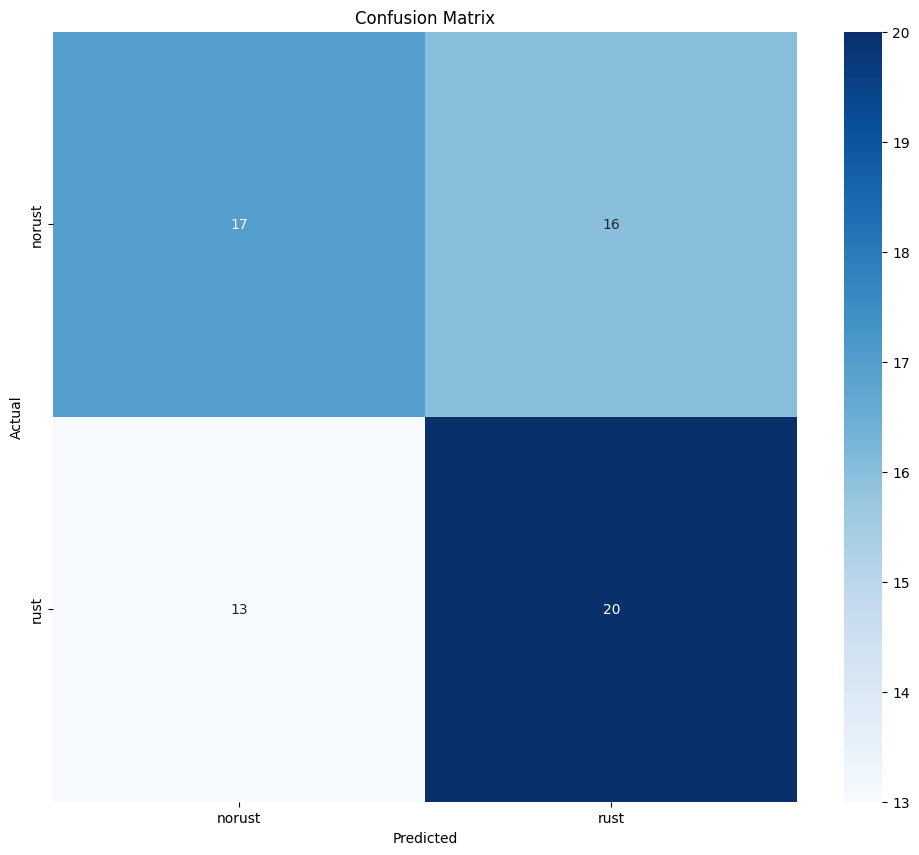

              precision    recall  f1-score   support

      norust       0.57      0.52      0.54        33
        rust       0.56      0.61      0.58        33

    accuracy                           0.56        66
   macro avg       0.56      0.56      0.56        66
weighted avg       0.56      0.56      0.56        66



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the true labels and predicted labels for the test data
true_labels = validation_gen.classes
predicted_labels = np.argmax(model.predict(validation_gen), axis=1)

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=validation_gen.class_indices, yticklabels=validation_gen.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
class_names = list(validation_gen.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

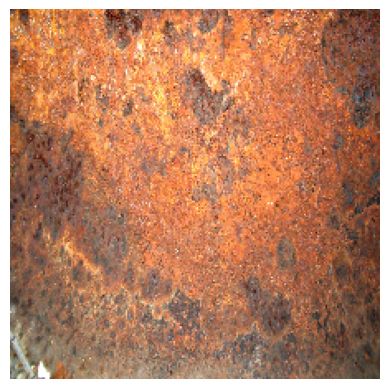

1/1 [==============================] - 0s 31ms/step
True label: rust
Predicted label: rust


In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in validation_gen.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(validation_gen)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

# 5. Saving Model

saving model into .pb and .h5

In [ ]:
# Save Model
os.chdir("/content/drive/MyDrive/Machine Learning/model")
model_dir = '/content/drive/MyDrive/Machine Learning/model/'
tf.saved_model.save(model, model_dir)
model.save("Xception_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


converting .pb into .tflite

In [ ]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir=model_dir)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('./Xception_model.tflite')
tflite_model_file.write_bytes(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
q_tflite_model = converter.convert()
q_tflite_model_file = pathlib.Path('./quantized_Xception_model.tflite')
q_tflite_model_file.write_bytes(q_tflite_model)

22101304